In [33]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import time

In [26]:
# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4,1)
    train_set.append((train_set_features[i].reshape(102,1), label))
    

for i in range(len(test_set_features)):
    label = np.array([0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4,1)
    test_set.append((test_set_features[i].reshape(102,1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

In [27]:
def sigmoid(z):
    return 1/(1 + np.exp(-z, dtype=np.longdouble))

def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [47]:
class MLP:
    
    weights: list[np.ndarray]
    biases: list[np.ndarray]
    
    def __init__(self, layers_size: list[tuple[int, int]]):
        self.weights = []
        self.biases = []
        self.learning_rate = 1
        
        for size in layers_size:
            self.weights.append(np.random.normal(size=size))
            self.biases.append(np.zeros((1, size[1])).astype(np.longdouble))
        
        self.layers_number = len(self.weights)

    def feed(self, data):
        W = self.weights
        b = self.biases
        
        result = []
        o = sigmoid(W[0].T.dot(data) + b[0].T)
        result.append(o)
        for i in range(1, self.layers_number):
            o = sigmoid(W[i].T.dot(o) + b[i].T)
            result.append(o)
        return result
    
    def train(self, x, y, batch_size=10, epoch_number=5, validation=0.2):
        w = self.weights
        b = self.biases
        
        # Seperating validation and train
        seperator_index = int(validation * x.shape[1])
        x_valid = x[:, :seperator_index]
        y_valid = y[:, :seperator_index]
        x_train = x[:, seperator_index:]
        y_train = y[:, seperator_index:]
        
        # Performing learning algorithm
        validation_values = []
        for i in range(epoch_number):
            cost = 0
            for j in range(0, x.shape[1], batch_size):
                data = x_train[:, j:j+batch_size]       # A batch of inputs
                y_ex = y_train[:, j:j+batch_size]       # Expected Output
                out = self.feed(data)             # Outputs of each layer for the given batch
                
                m = data.shape[1]
                if m == 0:
                    continue
                
                # Back Propagation Phase
                d_loss = self.d_loss_function(out[2], y_ex)
                cost += np.sum(d_loss * d_loss) / (2*m)
                e2 = d_loss * d_sigmoid(out[2])
                e1 = w[2].dot(e2) * d_sigmoid(out[1])
                e0 = w[1].dot(e1) * d_sigmoid(out[0])
                
                w[0] -= self.learning_rate * (1/m) * data.dot(e0.T)
                w[1] -= self.learning_rate * (1/m) * out[0].dot(e1.T)
                w[2] -= self.learning_rate * (1/m) * out[1].dot(e2.T)
                
                b[0] -= self.learning_rate * (1/m) * np.sum(e0.T, axis=0)
                b[1] -= self.learning_rate * (1/m) * np.sum(e1.T, axis=0)
                b[2] -= self.learning_rate * (1/m) * np.sum(e2.T, axis=0)
            validation_values.append(cost)
            
        plt.plot(range(epoch_number), validation_values)
    
    def test(self, x, y):
        out = self.feed(x)
        maximum = np.argmax(out[-1], axis=0)
        equality = (maximum == np.argmax(y, axis=0)).astype('int')
        return sum(equality) / y.shape[1]
    
    def d_loss_function(self, output, y_expected, function_type='SSE'):
        if function_type == 'SSE':
            return output - y_expected
        


In [29]:
# Seperate x and y of train set
x_train = np.column_stack([i[0] for i in train_set])
y_train = np.column_stack([i[1] for i in train_set])

# Seperate x and y of test set
x_test = np.column_stack([i[0] for i in test_set])
y_test = np.column_stack([i[1] for i in test_set])

# Train by 200 items

Here we train our model by 200 items of train set and finally we will witness that it has accuracy around 0.95.

Accuracy before train: 0.235
Training finished with in 0.2590811252593994 s
Accuracy after train: 0.9909365558912386


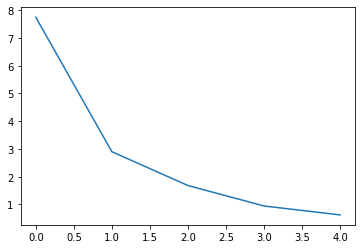

In [48]:
# Create neural network object
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Using 200 items of test set to see the accuracy for Phase 1
print('Accuracy before train:', mlp.test(x_test[:, :200], y_test[:, :200]))

# Training the model
tik = time.time()
mlp.train(x_train[:, :200], y_train[:, :200])
tok = time.time()
print('Training finished with in', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))

# Train and Test with whole datasets

In this part first we make a numpy array of the train_set and test_set. After that we seperate 200 items of test set to see the accuray of model. It is close to 0.25 normally. Then we train an we will see the accuracy rises up to 1.0.

Accuracy before train: 0.26
Training finished with in 3.6468679904937744 s
Accuracy after train: 1.0


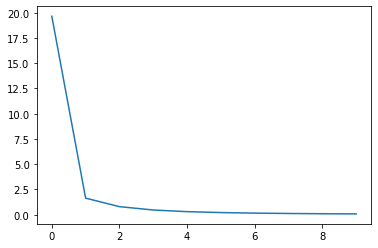

In [49]:
# Create neural network object
mlp = MLP([(102, 150), (150, 60), (60, 4)])

# Using 200 items of test set to see the accuracy for Phase 1
print('Accuracy before train:', mlp.test(x_test[:, :200], y_test[:, :200]))

# Training the model
tik = time.time()
mlp.train(x_train, y_train, epoch_number=10)
tok = time.time()
print('Training finished with in', tok - tik, 's')

# Using whole test set to see the accuracy
print('Accuracy after train:', mlp.test(x_test, y_test))

In [44]:
np.sum(np.array([[1, 1, 1],
                [2, 2, 2]]))

9